In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 24.7 MB/s eta 0:00:0

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 39.1 MB/s eta 0:00:00


In [3]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
# Import the libraries
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TextClassificationPipeline
from datasets import Dataset
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
import torch
import shap

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## Loading data and pre-processing

In [8]:
# Loading datasets from disk
true_data = pd.read_csv("DataSet_Misinfo_TRUE.csv")
fake_data = pd.read_csv("DataSet_Misinfo_FAKE.csv")
prop_data = pd.read_csv("EXTRA_RussianPropagandaSubset.csv")

In [9]:
# Add labels to the loaded data
true_data["label"] = 0
fake_data['label'] = 1
prop_data['label'] = 1

In [10]:
# Merge the datasets into one
data = pd.concat([true_data, fake_data, prop_data])

In [11]:
# Handling missing values by removing them from the data
print(data.shape)
data.dropna(inplace= True)
print(data.shape)

data.head()

(85986, 3)
(85954, 3)


,Unnamed: 0,text,label
0,0,The head of a conservative Republican faction ...,0
1,1,Transgender people will be allowed for the fir...,0
2,2,The special counsel investigation of links bet...,0
3,3,Trump campaign adviser George Papadopoulos tol...,0
4,4,President Donald Trump called on the U.S. Post...,0


In [12]:
# Check data distribution
cnt = Counter(data['label'])
print(f"The data distribution is {cnt}")
dif = np.abs(cnt[0] - cnt[1])
print(f"The data difference is {dif}")

The data distribution is Counter({1: 51008, 0: 34946})
The data difference is 16062


In [13]:
# Balance the dataset
data_bal = pd.concat([data, data[data['label'] == 0].sample(dif)])
Counter(data_bal['label'])

Counter({0: 51008, 1: 51008})

In [14]:
# Drop the index column
data_bal.drop(['Unnamed: 0'], axis = 1, inplace= True)

In [16]:
# Split data into train, test, and validation sets
dev_data, test_data = train_test_split(data_bal, test_size = 0.2)
train_data, validation_data = train_test_split(dev_data, test_size = 0.1)

In [17]:
# Convert Dataframes to hugging face datasets to make it ready for transformer model
ds_train = Dataset.from_pandas(train_data)
ds_validation = Dataset.from_pandas(validation_data)
ds_test = Dataset.from_pandas(test_data)

## Define model and tokenizer

In [ ]:
# Define our model
model_name = 'distilbert-base-uncased'

# Load the tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizer function
def tokenizer_function(examples):
    return tokenizer(examples['text'], truncation = True, padding = True, max_length= 512)

# Encode train and validation data using the defined tokenizer
encoded_dataset_train = ds_train.map(tokenizer_function, batched = True)
encoded_dataset_valid = ds_validation.map(tokenizer_function, batched = True)
encoded_dataset_test = ds_test.map(tokenizer_function, batched = True)

Map:   0%|          | 0/73450 [00:00<?, ? examples/s]

Map:   0%|          | 0/8162 [00:00<?, ? examples/s]

Map:   0%|          | 0/20404 [00:00<?, ? examples/s]

In [ ]:
# Compute- metric function 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Define training arguments
args = TrainingArguments(
    output_dir = "./results",
    num_train_epochs = 5,
    per_device_train_batch_size= 32,
    per_device_eval_batch_size= 32,
    learning_rate= 5e-05,
    evaluation_strategy= "epoch",
    save_strategy= "epoch",
    load_best_model_at_end= True,
    seed = 789,
    weight_decay= 0.1,

)

In [ ]:
# Define the model and trainer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)
trainer = Trainer(
    model = model,
    args = args,
    train_dataset= encoded_dataset_train,
    eval_dataset= encoded_dataset_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

C:\Users\sbaha\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sbaha\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projecto

In [ ]:
# train the model
trainer.train()

C:\Users\sbaha\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Visualization

In [19]:
# List of all countries for the task-specific visualization
countries = ['United State', 'Russia', 'U.S.','US', 'Afghanistan', 'Aland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bonaire, Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Botswana', 'Bouvet Island', 'Brazil', 'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island', 'Cocos (Keeling) Islands', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Cook Islands', 'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Heard Island and McDonald Islands', 'Holy See (Vatican City State)', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', "Korea, Democratic People's Republic of", 'Korea, Republic of', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macao', 'Macedonia, Republic of', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Marshall Islands', 'Martinique', 'Mauritania', 'Mauritius', 'Mayotte', 'Mexico', 'Micronesia, Federated States of', 'Moldova, Republic of', 'Monaco', 'Mongolia', 'Montenegro', 'Montserrat', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau', 'Palestinian Territory, Occupied', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Pitcairn', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Réunion', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Barthélemy', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Martin (French part)', 'Saint Pierre and Miquelon', 'Saint Vincent and the Grenadines', 'Samoa', 'San Marino', 'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Singapore', 'Sint Maarten (Dutch part)', 'Slovakia', 'Slovenia', 'Solomon Islands', 'Somalia', 'South Africa', 'South Georgia and the South Sandwich Islands', 'Spain', 'Sri Lanka', 'Sudan', 'Suriname', 'South Sudan', 'Svalbard and Jan Mayen', 'Swaziland', 'Sweden', 'Switzerland', 'Syrian Arab Republic', 'Taiwan, Province of China', 'Tajikistan', 'Tanzania, United Republic of', 'Thailand', 'Timor-Leste', 'Togo', 'Tokelau', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'United States Minor Outlying Islands', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela, Bolivarian Republic of', 'Viet Nam', 'Virgin Islands, British', 'Virgin Islands, U.S.', 'Wallis and Futuna', 'Yemen', 'Zambia', 'Zimbabwe']

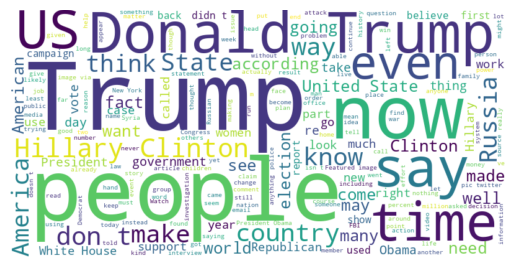

In [20]:
# Global visualization for fake news
text = " ".join(t for t in fake_data['text'])
stopwords = set(STOPWORDS)
stopwords.update(["one", "U", "said", "S", "will"])
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("fake.png")

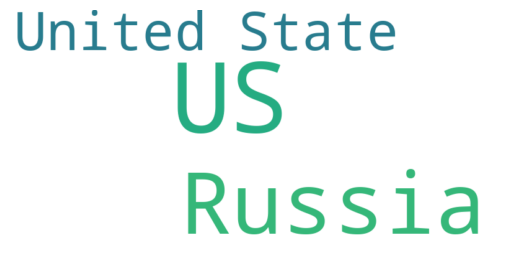

In [21]:
# Task-specific visualization for fake news
country_dict = {}
for item in wordcloud.words_:
    if item in countries:
        country_dict[item] = wordcloud.words_[item]
wordcloud2 = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate_from_frequencies(country_dict)


# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud2.to_file("fake_countries.png")

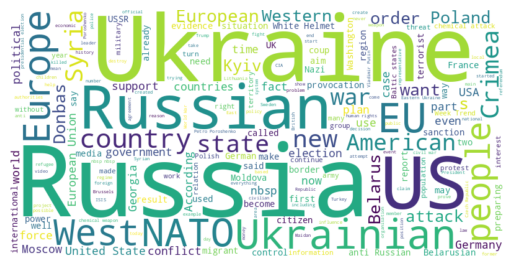

In [22]:
# Global visualization for propaganda news
prop_data.dropna(inplace = True)
text = " ".join(t for t in prop_data['text'])
stopwords = set(STOPWORDS)
stopwords.update(["one", "U", "will"])
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("prop.png")

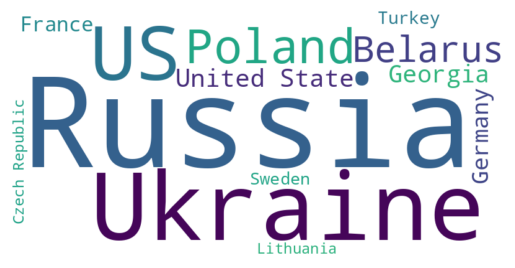

In [23]:
# Task-specific visualization for propaganda news
country_dict = {}
for item in wordcloud.words_:
    if item in countries:
        country_dict[item] = wordcloud.words_[item]
        
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white").generate_from_frequencies(country_dict)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("prop_countries.png")

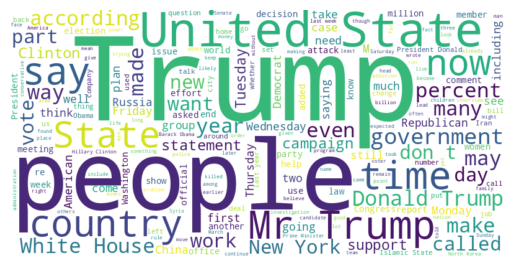

In [24]:
# Global visualization for true news
true_data.dropna(inplace = True)
text = " ".join(t for t in true_data['text'])
stopwords = set(STOPWORDS)
stopwords.update(["s", "U", "one", "said", "will"])
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("true.png")

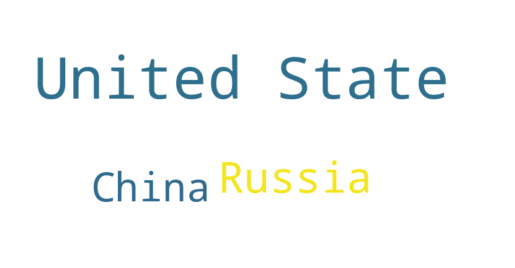

In [25]:
# Task-specific visualization for true news
country_dict = {}
for item in wordcloud.words_:
    if item in countries:
        country_dict[item] = wordcloud.words_[item]
        
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="white").generate_from_frequencies(country_dict)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("true_countries.png")

In [44]:
# Define the infereing pipeline
pipe = TextClassificationPipeline(model = model, tokenizer = tokenizer, return_all_scores = True)

`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


In [76]:
# getting an instance to detect and visualize
text = true_data.iloc[5]['text']
text

'The White House said on Friday it was set to kick off talks next week with Republican and Democratic congressional leaders on immigration policy, government spending and other issues that need to be wrapped up early in the new year. The expected flurry of legislative activity comes as Republicans and Democrats begin to set the stage for midterm congressional elections in November. President Donald Trump’s Republican Party is eager to maintain control of Congress while Democrats look for openings to wrest seats away in the Senate and the House of Representatives. On Wednesday, Trump’s budget chief Mick Mulvaney and legislative affairs director Marc Short will meet with Senate Majority Leader Mitch McConnell and House Speaker Paul Ryan'

In [51]:
# Move the model to CPU to make it ready for the shap
device = torch.device('cpu')
model.to(device)

In [77]:
# Infere for the given text
prediction = pipe([text])

In [78]:
# The detection result
prediction[0]

[{'label': 'LABEL_0', 'score': 0.9999911785125732},
 {'label': 'LABEL_1', 'score': 8.825491022435017e-06}]

In [79]:
# Define the shap explainer
explainer = shap.Explainer(pipe)

In [80]:
# Calculate shapley values
shap_values = explainer([text])

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [01:21, 81.06s/it]               


In [82]:
# Visualize the interactive word importance for the given instance
shap.plots.text(shap_values)

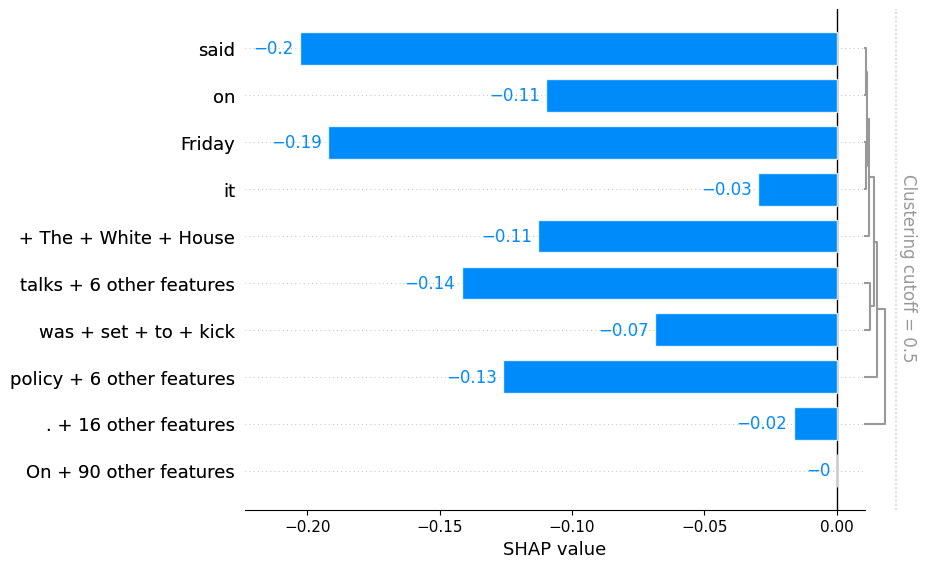

In [84]:
# Generate other instant-based visualizations
shap.plots.bar(shap_values[0,:,1])

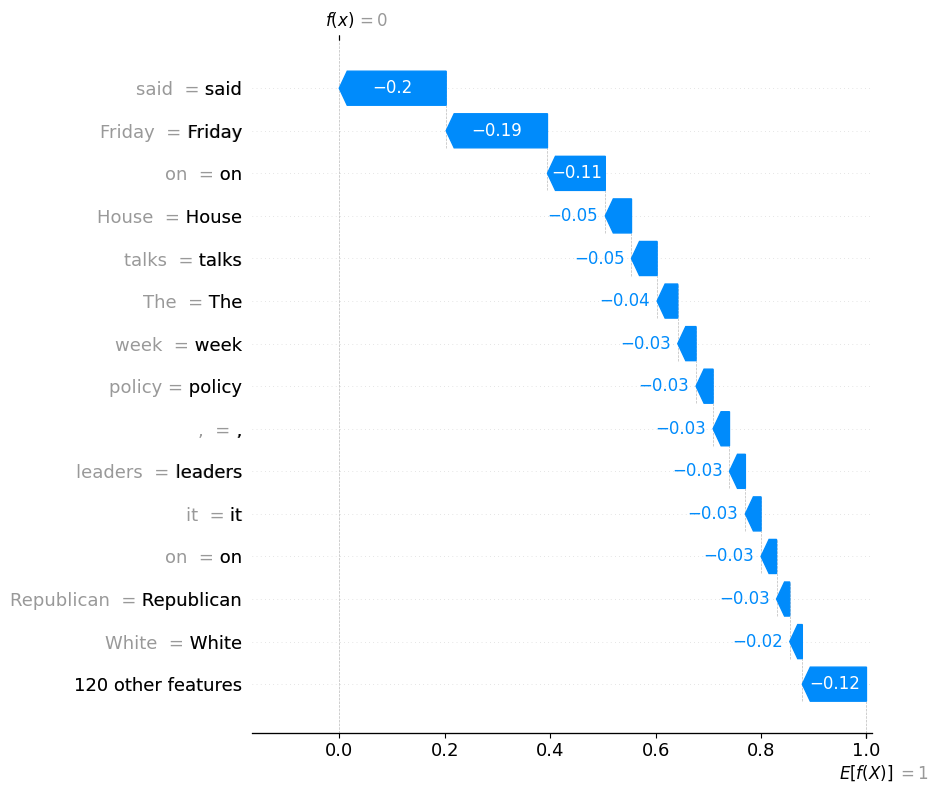

In [87]:
# Generate other instant-based visualizations
shap.waterfall_plot(shap_values[0][:, 1], max_display=15)

## Save and Load  model

In [27]:
import tarfile
import os.path


In [ ]:
def make_tarfile(output_filename, source_dir):
  '''
  This function get a folder and a filename and compress that folder into the given filename
  '''
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

In [28]:
def uncompress_tarfile(filename, trg_dir):
  '''
  This function get a filename and a folder and extract the file into the given folder
  '''
    file = tarfile.open(filename)
  
    # extracting file
    file.extractall(trg_dir)

    file.close()

In [ ]:
# Compress and save the best model
output_filename = "best_model.tar.gz"
source_dir = "results/checkpoint-11480/"
make_tarfile(output_filename, source_dir)

In [29]:
# Extract the compressed model
filename = "best_model.tar.gz"
trg_dir = "model/"
uncompress_tarfile(filename, trg_dir)

In [31]:
# Load saved model 
model = AutoModelForSequenceClassification.from_pretrained("model/")
tokenizer = AutoTokenizer.from_pretrained("model/")

In [32]:
# Define a trainer for the loaded model
trainer = Trainer(model = model)


In [33]:
# Tokenizer function
def tokenizer_function(examples):
    return tokenizer(examples['text'], truncation = True, padding = True, max_length= 512)

In [34]:
# Make the test data ready for the evaluation
encoded_data = ds_test.map(tokenizer_function, batched = True)
# Infere the test data using the loaded model
with torch.no_grad():
    y_pred, y_act, _ = trainer.predict(encoded_data)

Map:   0%|          | 0/20404 [00:00<?, ? examples/s]

In [37]:
# Get the final labels
y_m = np.argmax(y_pred, axis = 1)
y_m


array([1, 0, 1, ..., 1, 1, 0])

In [42]:
# Calculate and show the evaluation metrics
print(classification_report(y_act, y_m, digits = 4))

              precision    recall  f1-score   support

           0     0.9976    0.9992    0.9984     10188
           1     0.9992    0.9976    0.9984     10216

    accuracy                         0.9984     20404
   macro avg     0.9984    0.9984    0.9984     20404
weighted avg     0.9984    0.9984    0.9984     20404



In [85]:
def cf(y_true, y_pred, fname, title):
    '''
    Create a confusion matrix plot save it into a file
    Inputs:
    y_true: actual labels
    y_pred: prediction labels
    fname: file name
    title: title of the plot
    Outputs:
    None
    '''
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    ax = sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='')
    ax.set_title(title);
    ax.xaxis.set_ticklabels(['True','Fake'])
    ax.yaxis.set_ticklabels(['True','Fake'])
    plt.savefig(fname, dpi=300)
    plt.show()

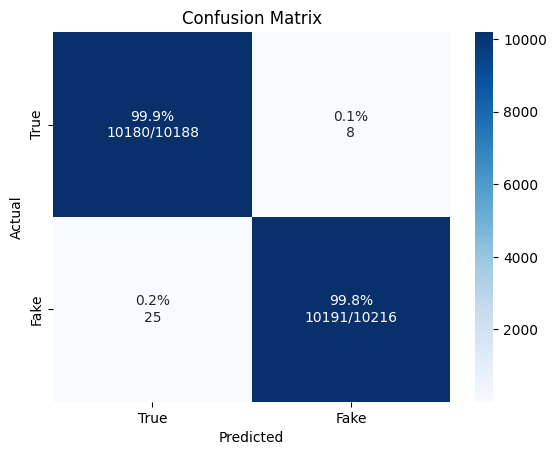

In [86]:
# Calculate and show the confusion matrix
cf(y_act, y_m, "cm", "Confusion Matrix")